# Analisis Pengaruh Tingkat Pendidikan terhadap Tingkat Pengangguran di Indonesia

## Business Understanding
Tujuan dari proyek ini adalah untuk memahami pengaruh rata-rata tingkat pendidikan terhadap tingkat pengangguran di berbagai provinsi di Indonesia.

Dengan menggunakan metode **K-Means Clustering**, kita dapat mengelompokkan provinsi berdasarkan karakteristik pendidikan dan penganggurannya. Selain itu, dengan **Decision Tree** dan **Regresi Linear**, kita dapat membangun model prediksi dan mengukur kekuatan hubungan linear antar variabel.

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('dataset_tubes.csv')
df.head()

,Periode,Bulan,Tidak/belum pernah sekolah,Tidak/belum tamat SD,SD,SLTP,SLTA Umum/SMU,SLTA Kejuruan/SMK,Akademi/Diploma,Universitas,Total
0,2006,Februari,234465,614960,2675459,2860007,2842876,1204140,297185,375601,11104693
1,2006,Agustus,170666,611254,2589699,2730045,2851518,1305190,278074,395554,10932000
2,2007,Februari,145750,520316,2753548,2643062,2630360,1114675,330316,409890,10547917
3,2007,Agustus,94301,438519,2179792,2264198,2532204,1538349,397191,566588,10011142
4,2008,Februari,79764,448431,2216748,2166619,2204377,1165582,519867,626202,9427590


## Exploratory Data Analysis

In [55]:

# Asumsi lama tahun pendidikan
tahun_pendidikan = {
    'Tidak/belum pernah sekolah': 0,
    'Tidak/belum tamat SD': 3,
    'SD': 6,
    'SLTP': 9,
    'SLTA Umum/SMU': 12,
    'SLTA Kejuruan/SMK': 12,
    'Akademi/Diploma': 14,
    'Universitas': 16
}

# Hitung total populasi berpendidikan dan jumlah tahun total
df['Total_Pendidikan_Terpenuhi'] = (
    df['Tidak/belum pernah sekolah'] * tahun_pendidikan['Tidak/belum pernah sekolah'] +
    df['Tidak/belum tamat SD'] * tahun_pendidikan['Tidak/belum tamat SD'] +
    df['SD'] * tahun_pendidikan['SD'] +
    df['SLTP'] * tahun_pendidikan['SLTP'] +
    df['SLTA Umum/SMU'] * tahun_pendidikan['SLTA Umum/SMU'] +
    df['SLTA Kejuruan/SMK'] * tahun_pendidikan['SLTA Kejuruan/SMK'] +
    df['Akademi/Diploma'] * tahun_pendidikan['Akademi/Diploma'] +
    df['Universitas'] * tahun_pendidikan['Universitas']
)

df['Pendidikan_RataRata'] = df['Total_Pendidikan_Terpenuhi'] / df['Total']
df.head()

,Periode,Bulan,Tidak/belum pernah sekolah,Tidak/belum tamat SD,SD,SLTP,SLTA Umum/SMU,SLTA Kejuruan/SMK,Akademi/Diploma,Universitas,Total,Total_Pendidikan_Terpenuhi,Pendidikan_RataRata
0,2006,Februari,234465,614960,2675459,2860007,2842876,1204140,297185,375601,11104693,102372095,9.218814
1,2006,Agustus,170666,611254,2589699,2730045,2851518,1305190,278074,395554,10932000,102044757,9.334500
2,2007,Februari,145750,520316,2753548,2643062,2630360,1114675,330316,409890,10547917,97992878,9.290259
3,2007,Agustus,94301,438519,2179792,2264198,2532204,1538349,397191,566588,10011142,98244809,9.813547
4,2008,Februari,79764,448431,2216748,2166619,2204377,1165582,519867,626202,9427590,91882230,9.746099


In [56]:

# Simulasi: semakin tinggi rata-rata pendidikan, semakin rendah tingkat pengangguran
np.random.seed(42)
df['Tingkat_Pengangguran'] = 12 * np.exp(-0.2 * df['Pendidikan_RataRata']) + np.random.normal(0, 0.3, size=len(df))
df['Tingkat_Pengangguran'] = df['Tingkat_Pengangguran'].clip(lower=1)  # minimal 1%
df[['Periode', 'Pendidikan_RataRata', 'Tingkat_Pengangguran']].head()

,Periode,Pendidikan_RataRata,Tingkat_Pengangguran
0,2006,9.218814,2.047666
1,2006,9.334500,1.813747
2,2007,9.290259,2.066021
3,2007,9.813547,2.142637
4,2008,9.746099,1.638375


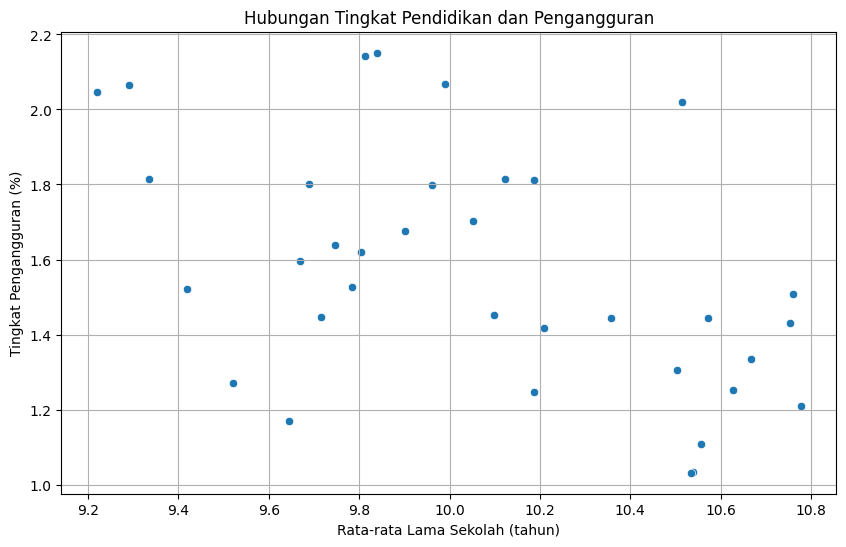

In [57]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='Pendidikan_RataRata', y='Tingkat_Pengangguran', data=df)
plt.title('Hubungan Tingkat Pendidikan dan Pengangguran')
plt.xlabel('Rata-rata Lama Sekolah (tahun)')
plt.ylabel('Tingkat Pengangguran (%)')
plt.grid(True)
plt.show()

## K-Means Clustering

In [58]:
def find_outlier_boundary(df, variable):


    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * 1.5)
    upper_boundary = df[variable].quantile(0.75) + (IQR * 1.5)

    return upper_boundary, lower_boundary

In [59]:
full_occup_upper_limit, full_occup_lower_limit = find_outlier_boundary(df,'Universitas')
full_occup_upper_limit, full_occup_lower_limit

(np.float64(1036088.5), np.float64(255484.5))

In [60]:
full_occup_upper_limit, full_occup_lower_limit = find_outlier_boundary(df,'Tidak/belum pernah sekolah')
full_occup_upper_limit, full_occup_lower_limit

(np.float64(211656.5), np.float64(-65239.5))

In [61]:
data_clf = df[(df['Tidak/belum pernah sekolah'] <= full_occup_upper_limit) & (df['Tidak/belum pernah sekolah'] >= full_occup_lower_limit)]

In [62]:
data_clf = df[(df['Tidak/belum pernah sekolah'] <= full_occup_upper_limit) & (df['Universitas'] >= full_occup_lower_limit)]

In [63]:
print(data_clf.columns.tolist())



['Periode', 'Bulan', 'Tidak/belum pernah sekolah', 'Tidak/belum tamat SD', 'SD', 'SLTP', 'SLTA Umum/SMU', 'SLTA Kejuruan/SMK', 'Akademi/Diploma', 'Universitas', 'Total', 'Total_Pendidikan_Terpenuhi', 'Pendidikan_RataRata', 'Tingkat_Pengangguran']


In [64]:
data_clf.head()

,Periode,Bulan,Tidak/belum pernah sekolah,Tidak/belum tamat SD,SD,SLTP,SLTA Umum/SMU,SLTA Kejuruan/SMK,Akademi/Diploma,Universitas,Total,Total_Pendidikan_Terpenuhi,Pendidikan_RataRata,Tingkat_Pengangguran
1,2006,Agustus,170666,611254,2589699,2730045,2851518,1305190,278074,395554,10932000,102044757,9.334500,1.813747
2,2007,Februari,145750,520316,2753548,2643062,2630360,1114675,330316,409890,10547917,97992878,9.290259,2.066021
3,2007,Agustus,94301,438519,2179792,2264198,2532204,1538349,397191,566588,10011142,98244809,9.813547,2.142637
4,2008,Februari,79764,448431,2216748,2166619,2204377,1165582,519867,626202,9427590,91882230,9.746099,1.638375
5,2008,Agustus,103206,443832,2099968,1973986,2403394,1409128,362683,598318,9394515,92098092,9.803390,1.618914


In [65]:
# Ubah nama kolom jika perlu
data_clf.rename(columns=lambda x: x.strip(), inplace=True)

# Bersihkan nilai NaN dan spasi
data_clf['Universitas'] = data_clf['Universitas'].astype(str).str.strip()
data_clf = data_clf[data_clf['Universitas'].notnull()]
data_clf = data_clf[data_clf['Universitas'] != '']

In [66]:


def check_plot(data, column_name):
    # Bersihkan kolom yang akan digunakan
    data[column_name] = data[column_name].astype(str).str.strip()
    data = data[data[column_name].notnull()]
    data = data[data[column_name] != '']

    plt.figure(figsize=(10, 6))
    sns.countplot(data=data, x=column_name, order=data[column_name].value_counts().index)
    plt.title(f'Count Plot of {column_name}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


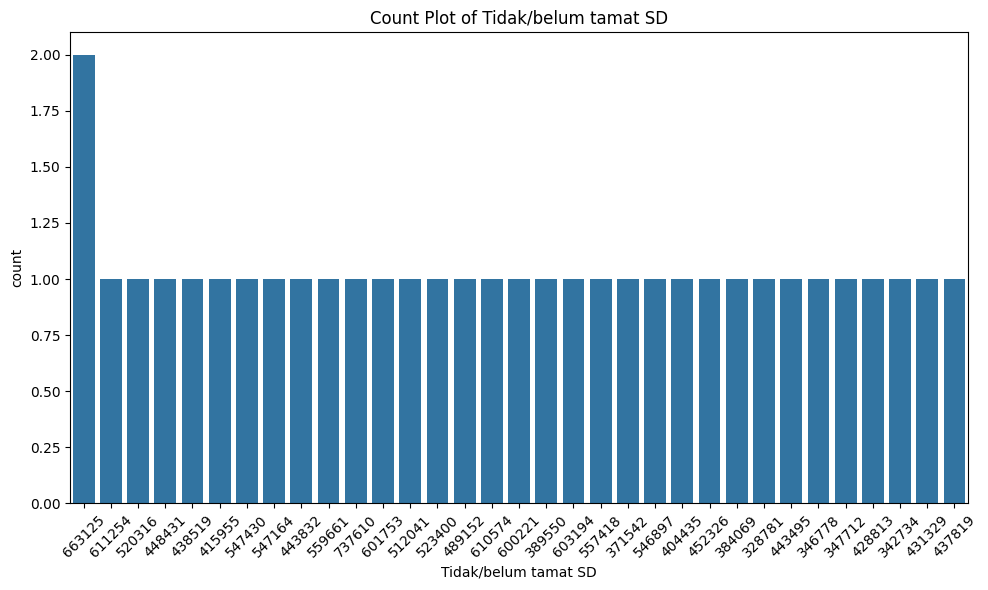

In [67]:
check_plot(data_clf, 'Tidak/belum tamat SD')

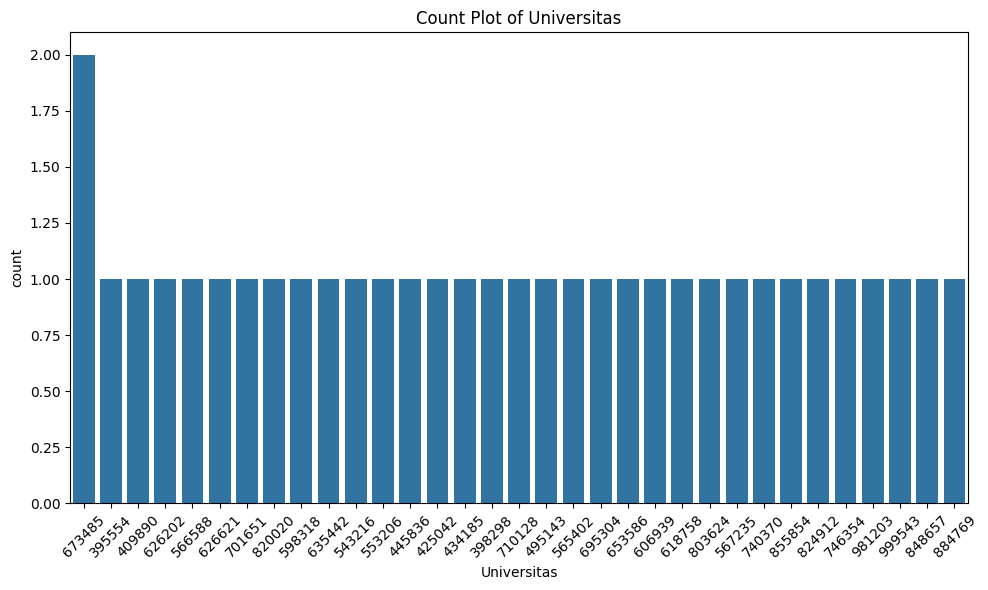

In [68]:
check_plot(data_clf, 'Universitas')

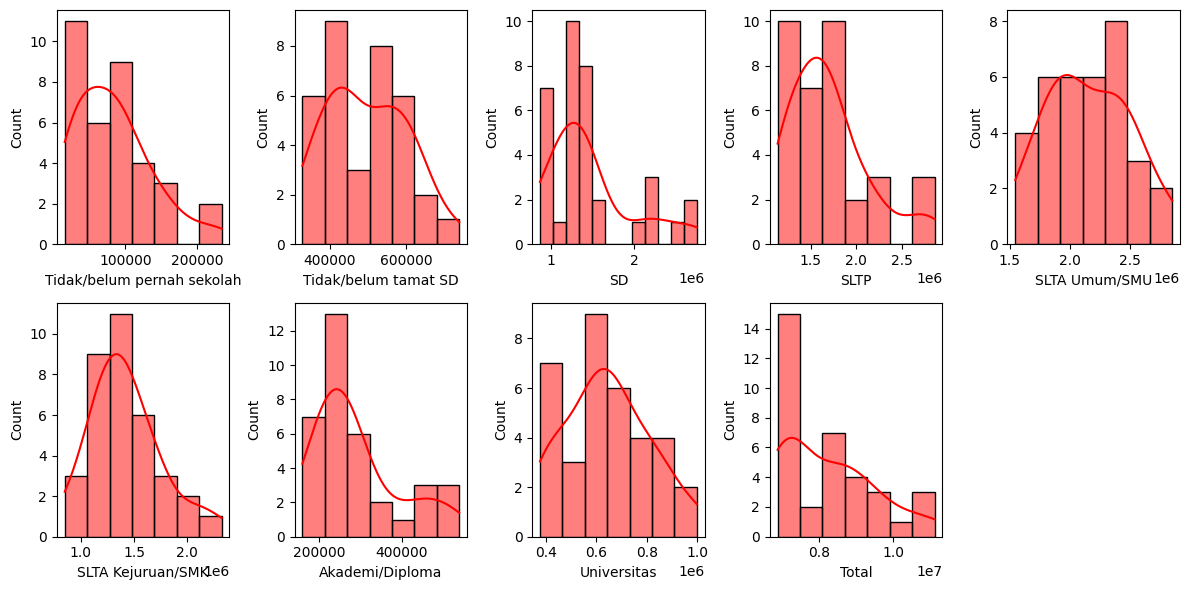

In [69]:
plt.figure(figsize=(12,6))

# Define the list of numerical features you want to plot
numericals = ['Tidak/belum pernah sekolah', 'Tidak/belum tamat SD', 'SD', 'SLTP', 'SLTA Umum/SMU', 'SLTA Kejuruan/SMK', 'Akademi/Diploma', 'Universitas', 'Total']

features = numericals
for i in range(0, len(features)):
    plt.subplot(2, len(features)//2 + 1, i+1)
    sns.histplot(x=df[features[i]], color='red', kde=True)
    plt.xlabel(features[i])
    plt.tight_layout()
plt.show()

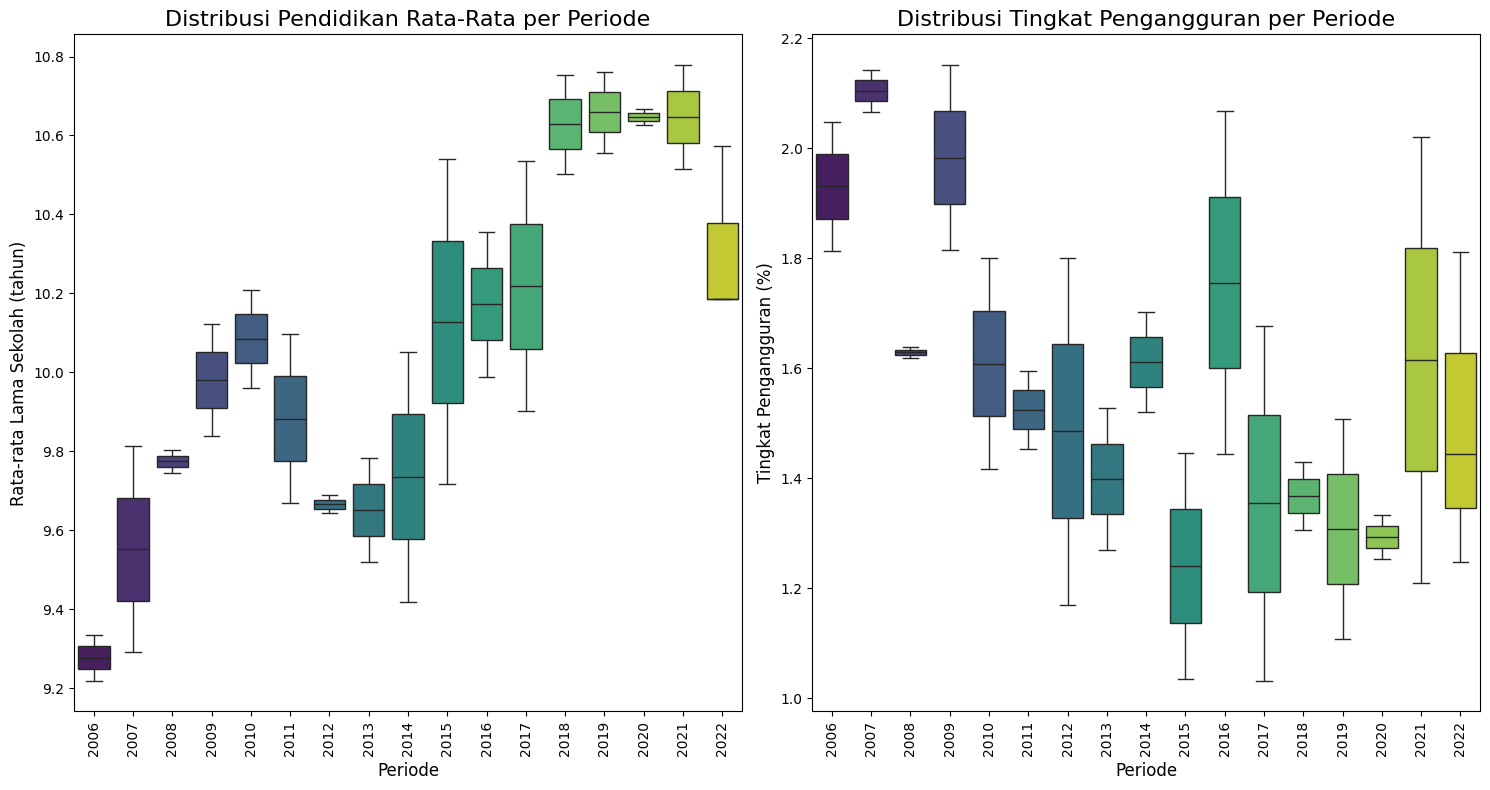

In [70]:
plt.figure(figsize=(15, 8))

# Box plot untuk Pendidikan Rata-Rata
plt.subplot(1, 2, 1) # 1 baris, 2 kolom, plot ke-1
sns.boxplot(x='Periode', y='Pendidikan_RataRata', data=df, palette='viridis')
plt.title('Distribusi Pendidikan Rata-Rata per Periode', fontsize=16)
plt.xlabel('Periode', fontsize=12)
plt.ylabel('Rata-rata Lama Sekolah (tahun)', fontsize=12)
plt.xticks(rotation=90)
# Anda bisa sesuaikan batas sumbu y jika perlu, contoh: plt.ylim(0, df['Pendidikan_RataRata'].quantile(0.95))

# Box plot untuk Tingkat Pengangguran
plt.subplot(1, 2, 2) # 1 baris, 2 kolom, plot ke-2
sns.boxplot(x='Periode', y='Tingkat_Pengangguran', data=df, palette='viridis')
plt.title('Distribusi Tingkat Pengangguran per Periode', fontsize=16)
plt.xlabel('Periode', fontsize=12)
plt.ylabel('Tingkat Pengangguran (%)', fontsize=12)
plt.xticks(rotation=90)
# Anda bisa sesuaikan batas sumbu y jika perlu, contoh: plt.ylim(0, df['Tingkat_Pengangguran'].quantile(0.95))


plt.tight_layout()
plt.show()

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Periode                     35 non-null     int64  
 1   Bulan                       35 non-null     object 
 2   Tidak/belum pernah sekolah  35 non-null     int64  
 3   Tidak/belum tamat SD        35 non-null     int64  
 4   SD                          35 non-null     int64  
 5   SLTP                        35 non-null     int64  
 6   SLTA Umum/SMU               35 non-null     int64  
 7   SLTA Kejuruan/SMK           35 non-null     int64  
 8   Akademi/Diploma             35 non-null     int64  
 9   Universitas                 35 non-null     int64  
 10  Total                       35 non-null     int64  
 11  Total_Pendidikan_Terpenuhi  35 non-null     int64  
 12  Pendidikan_RataRata         35 non-null     float64
 13  Tingkat_Pengangguran        35 non-nu

In [72]:
df_filtered = df[df['Tingkat_Pengangguran'] > df['Tingkat_Pengangguran'].mean()]
df_filtered

,Periode,Bulan,Tidak/belum pernah sekolah,Tidak/belum tamat SD,SD,SLTP,SLTA Umum/SMU,SLTA Kejuruan/SMK,Akademi/Diploma,Universitas,Total,Total_Pendidikan_Terpenuhi,Pendidikan_RataRata,Tingkat_Pengangguran
0,2006,Februari,234465,614960,2675459,2860007,2842876,1204140,297185,375601,11104693,102372095,9.218814,2.047666
1,2006,Agustus,170666,611254,2589699,2730045,2851518,1305190,278074,395554,10932000,102044757,9.334500,1.813747
2,2007,Februari,145750,520316,2753548,2643062,2630360,1114675,330316,409890,10547917,97992878,9.290259,2.066021
3,2007,Agustus,94301,438519,2179792,2264198,2532204,1538349,397191,566588,10011142,98244809,9.813547,2.142637
4,2008,Februari,79764,448431,2216748,2166619,2204377,1165582,519867,626202,9427590,91882230,9.746099,1.638375
5,2008,Agustus,103206,443832,2099968,1973986,2403394,1409128,362683,598318,9394515,92098092,9.803390,1.618914
6,2009,Februari,60347,415955,2143747,2054682,2133627,1337586,486399,626621,9258964,91092563,9.838311,2.151163
7,2009,Agustus,90471,547430,1531671,1770823,2472245,1407226,441100,701651,8962617,90725191,10.122623,1.814910
9,2010,Agustus,157586,600221,1402858,1661449,2149123,1195192,443222,710128,8319779,82869788,9.960576,1.799647
11,2011,Agustus,205388,737610,1241882,2138864,2376254,1161362,276816,543216,8681392,83932170,9.668054,1.595781


In [73]:
periode_counts = df['Periode'].value_counts().sort_values(ascending=False)
periode_counts

Periode
2022    3
2006    2
2007    2
2009    2
2008    2
2011    2
2012    2
2013    2
2010    2
2014    2
2015    2
2017    2
2016    2
2018    2
2019    2
2020    2
2021    2
Name: count, dtype: int64

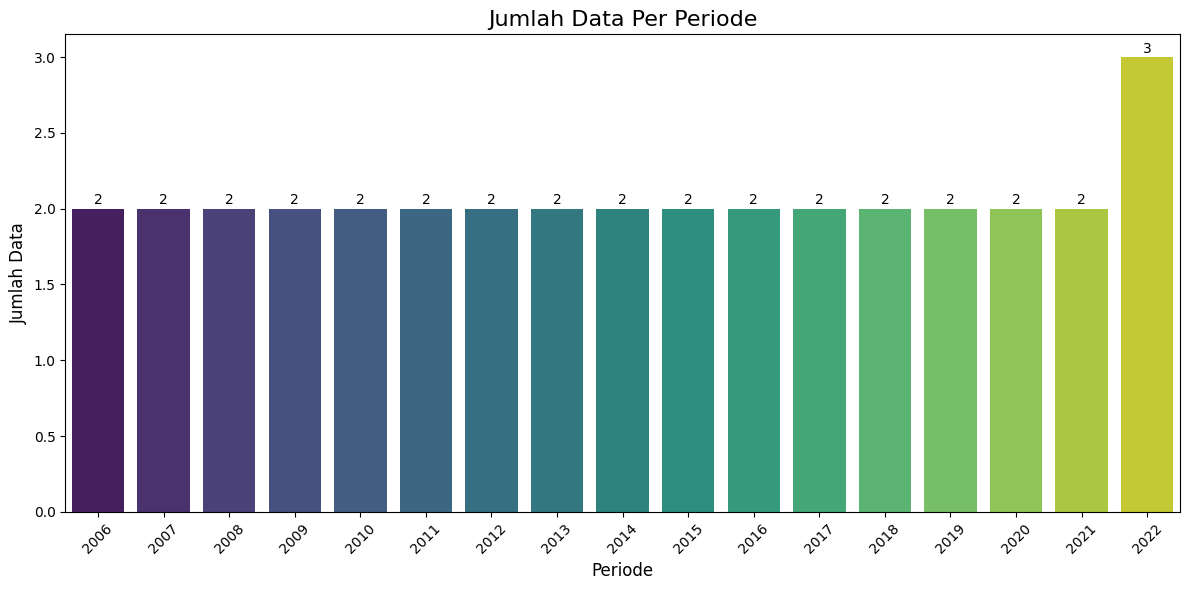

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

# Kolom yang berisi informasi periode quarter
kolom_periode_quarter = 'Periode' # Pastikan ini nama kolom yang benar

# Gunakan hasil perhitungan value_counts() dari kolom periode quarter
if kolom_periode_quarter in df.columns:
    periode_counts_df = df[kolom_periode_quarter].value_counts().reset_index()
    periode_counts_df.columns = [kolom_periode_quarter, 'Jumlah Data'] # Sesuaikan nama kolom

    # Mengurutkan periode (opsional tapi disarankan)
    # Ini mungkin memerlukan penyesuaian tergantung format eksak kolom 'Periode' Anda
    # Misalnya, jika formatnya "YYYY Qx", mengurutkan string mungkin sudah cukup
    periode_counts_df = periode_counts_df.sort_values(by=kolom_periode_quarter)

    plt.figure(figsize=(12, 6)) # Sesuaikan ukuran figure jika perlu
    sns.barplot(x=kolom_periode_quarter, y='Jumlah Data', data=periode_counts_df, palette='viridis')

    # Tambahkan label jumlah di atas bar
    for i, count in enumerate(periode_counts_df['Jumlah Data']):
        plt.text(i, count + (0.01 * periode_counts_df['Jumlah Data'].max()), f"{count:,.0f}",
                 ha='center', fontsize=10, color='black')

    plt.title(f'Jumlah Data Per {kolom_periode_quarter}', fontsize=16) # Judul plot
    plt.xlabel(kolom_periode_quarter, fontsize=12) # Label sumbu X
    plt.ylabel('Jumlah Data', fontsize=12) # Label sumbu Y
    plt.xticks(rotation=45) # Rotasi label sumbu X

    plt.tight_layout()
    plt.show()
else:
    print(f"Kolom '{kolom_periode_quarter}' tidak ditemukan di dataframe.")

In [75]:
df.columns

Index(['Periode', 'Bulan', 'Tidak/belum pernah sekolah',
       'Tidak/belum tamat SD', 'SD', 'SLTP', 'SLTA Umum/SMU',
       'SLTA Kejuruan/SMK', 'Akademi/Diploma', 'Universitas', 'Total',
       'Total_Pendidikan_Terpenuhi', 'Pendidikan_RataRata',
       'Tingkat_Pengangguran'],
      dtype='object')

In [76]:
# Example: Calculate average 'Tingkat_Pengangguran' per 'Periode'
avg_unemployment_by_period = df.groupby('Periode')['Tingkat_Pengangguran'].mean().sort_values(ascending=False)
print(avg_unemployment_by_period)

# Example: Calculate average 'Pendidikan_RataRata' per 'Periode'
avg_education_by_period = df.groupby('Periode')['Pendidikan_RataRata'].mean().sort_values(ascending=False)
print(avg_education_by_period)

Periode
2007    2.104329
2009    1.983036
2006    1.930706
2016    1.755895
2008    1.628645
2021    1.615087
2014    1.610994
2010    1.608078
2011    1.524637
2022    1.501074
2012    1.485477
2013    1.398784
2018    1.367595
2017    1.354226
2019    1.307487
2020    1.293204
2015    1.240346
Name: Tingkat_Pengangguran, dtype: float64
Periode
2019    10.658996
2021    10.646640
2020    10.646513
2018    10.628600
2022    10.314769
2017    10.218146
2016    10.172795
2015    10.127818
2010    10.085090
2009     9.980467
2011     9.883004
2008     9.774745
2014     9.735197
2012     9.666161
2013     9.651492
2007     9.551903
2006     9.276657
Name: Pendidikan_RataRata, dtype: float64


In [77]:
df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Periode                     35 non-null     int64  
 1   Bulan                       35 non-null     object 
 2   Tidak/belum pernah sekolah  35 non-null     int64  
 3   Tidak/belum tamat SD        35 non-null     int64  
 4   SD                          35 non-null     int64  
 5   SLTP                        35 non-null     int64  
 6   SLTA Umum/SMU               35 non-null     int64  
 7   SLTA Kejuruan/SMK           35 non-null     int64  
 8   Akademi/Diploma             35 non-null     int64  
 9   Universitas                 35 non-null     int64  
 10  Total                       35 non-null     int64  
 11  Total_Pendidikan_Terpenuhi  35 non-null     int64  
 12  Pendidikan_RataRata         35 non-null     float64
 13  Tingkat_Pengangguran        35 non-nu

(None,
    Periode     Bulan  Tidak/belum pernah sekolah  Tidak/belum tamat SD  \
 0     2006  Februari                      234465                614960   
 1     2006   Agustus                      170666                611254   
 2     2007  Februari                      145750                520316   
 3     2007   Agustus                       94301                438519   
 4     2008  Februari                       79764                448431   
 
         SD     SLTP  SLTA Umum/SMU  SLTA Kejuruan/SMK  Akademi/Diploma  \
 0  2675459  2860007        2842876            1204140           297185   
 1  2589699  2730045        2851518            1305190           278074   
 2  2753548  2643062        2630360            1114675           330316   
 3  2179792  2264198        2532204            1538349           397191   
 4  2216748  2166619        2204377            1165582           519867   
 
    Universitas     Total  Total_Pendidikan_Terpenuhi  Pendidikan_RataRata  \
 0       37

In [78]:

df.describe()

,Periode,Tidak/belum pernah sekolah,Tidak/belum tamat SD,SD,SLTP,SLTA Umum/SMU,SLTA Kejuruan/SMK,Akademi/Diploma,Universitas,Total,Total_Pendidikan_Terpenuhi,Pendidikan_RataRata,Tingkat_Pengangguran
count,35.000000,35.000000,35.000000,3.500000e+01,3.500000e+01,3.500000e+01,3.500000e+01,35.000000,35.000000,3.500000e+01,3.500000e+01,35.000000,35.000000
mean,2014.228571,83398.457143,496154.714286,1.462738e+06,1.697168e+06,2.153685e+06,1.422718e+06,290182.771429,642869.171429,8.247912e+06,8.280470e+07,10.067221,1.569151
std,5.082182,53949.291460,105794.400661,5.112940e+05,4.367373e+05,3.518458e+05,3.361657e+05,103575.191557,167112.979108,1.233931e+06,1.111764e+07,0.460007,0.321904
min,2006.000000,15206.000000,328781.000000,8.657780e+05,1.137195e+06,1.546699e+06,8.473650e+05,159490.000000,375601.000000,6.898796e+06,6.731635e+07,9.218814,1.031885
25%,2010.000000,38596.500000,422384.000000,1.219224e+06,1.343867e+06,1.902169e+06,1.184779e+06,219345.000000,548211.000000,7.125746e+06,7.282654e+07,9.731253,1.319558
50%,2014.000000,79764.000000,489152.000000,1.320392e+06,1.650387e+06,2.133627e+06,1.383022e+06,254457.000000,626621.000000,8.319779e+06,8.286979e+07,10.051659,1.520384
75%,2018.500000,107820.500000,579941.000000,1.487256e+06,1.828030e+06,2.437820e+06,1.595546e+06,317788.500000,743362.000000,9.032334e+06,9.148740e+07,10.524864,1.806246
max,2022.000000,234465.000000,737610.000000,2.753548e+06,2.860007e+06,2.851518e+06,2.326599e+06,538186.000000,999543.000000,1.110469e+07,1.041847e+08,10.778267,2.151163


In [79]:

# Kelompokkan data berdasarkan 'Periode' dan hitung rata-rata kolom yang relevan
periode_summary = df.groupby('Periode').agg(
    rata_rata_pendidikan=('Pendidikan_RataRata', 'mean'),
    rata_rata_pengangguran=('Tingkat_Pengangguran', 'mean'),
).reset_index()

# Cetak ringkasan per periode
print(periode_summary)

    Periode  rata_rata_pendidikan  rata_rata_pengangguran
0      2006              9.276657                1.930706
1      2007              9.551903                2.104329
2      2008              9.774745                1.628645
3      2009              9.980467                1.983036
4      2010             10.085090                1.608078
5      2011              9.883004                1.524637
6      2012              9.666161                1.485477
7      2013              9.651492                1.398784
8      2014              9.735197                1.610994
9      2015             10.127818                1.240346
10     2016             10.172795                1.755895
11     2017             10.218146                1.354226
12     2018             10.628600                1.367595
13     2019             10.658996                1.307487
14     2020             10.646513                1.293204
15     2021             10.646640                1.615087
16     2022   

In [80]:
df['profit'] = df['Tingkat_Pengangguran'] - df['Pendidikan_RataRata']

In [81]:
# Kelompokkan data berdasarkan 'Periode' dan hitung total 'profit' serta jumlah data per periode
periode_summary = df.groupby('Periode').agg(
    total_profit=('profit', 'sum'),
    jumlah_data=('Periode', 'count')  # Menghitung jumlah baris per periode
).reset_index()

# Cetak ringkasan per periode
print(periode_summary)

    Periode  total_profit  jumlah_data
0      2006    -14.691901            2
1      2007    -14.895148            2
2      2008    -16.292200            2
3      2009    -15.994860            2
4      2010    -16.954024            2
5      2011    -16.716734            2
6      2012    -16.361368            2
7      2013    -16.505416            2
8      2014    -16.248405            2
9      2015    -17.774943            2
10     2016    -16.833800            2
11     2017    -17.727840            2
12     2018    -18.522012            2
13     2019    -18.703018            2
14     2020    -18.706619            2
15     2021    -18.063106            2
16     2022    -26.441084            3


In [82]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import pickle

In [83]:
features_for_clustering = ['Pendidikan_RataRata', 'Tingkat_Pengangguran']
X = df[features_for_clustering]

In [84]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [85]:
inertias = []
silhouette_scores = []
k_range = range(2, 11)

In [86]:
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)

    inertias.append(kmeans.inertia_)


    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(score)

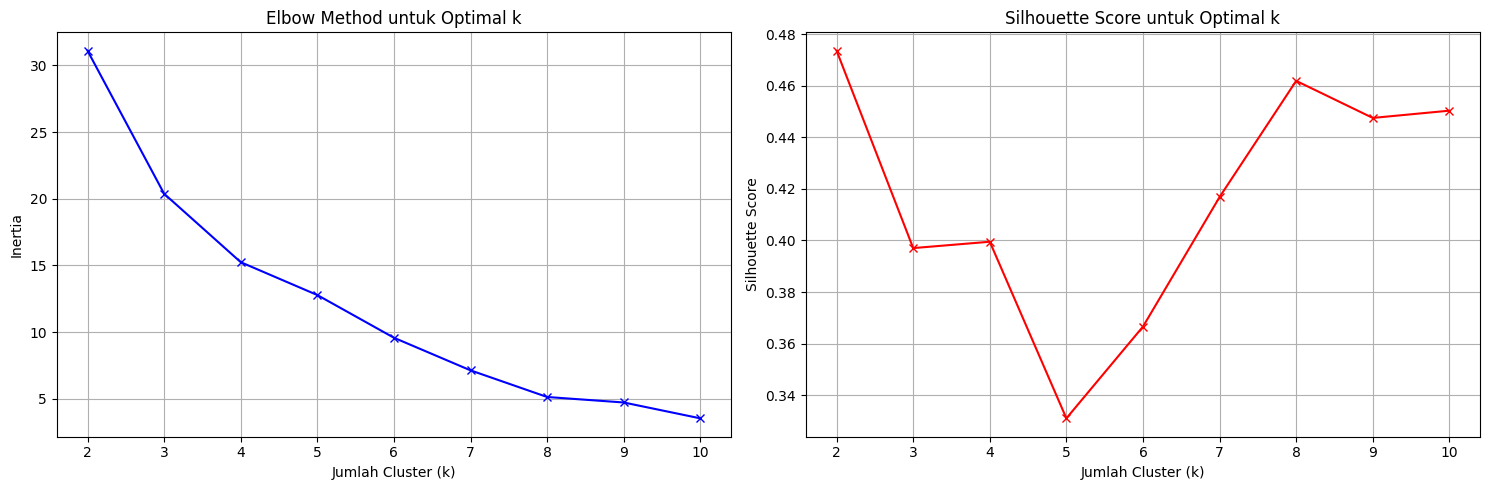


Nilai Silhouette Score untuk setiap k:
k=2: 0.4736
k=3: 0.3970
k=4: 0.3995
k=5: 0.3310
k=6: 0.3666
k=7: 0.4168
k=8: 0.4619
k=9: 0.4475
k=10: 0.4503


In [87]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertias, 'bx-')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method untuk Optimal k')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, 'rx-')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score untuk Optimal k')
plt.grid(True)

plt.tight_layout()
plt.show()

print("\nNilai Silhouette Score untuk setiap k:")
for k, score in zip(k_range, silhouette_scores):
    print(f"k={k}: {score:.4f}")

In [88]:
optimal_k = 3
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster'] = final_kmeans.fit_predict(X_scaled)

In [89]:
cluster_summary = df.groupby('cluster').agg({
    'Pendidikan_RataRata': 'mean',
    'Tingkat_Pengangguran': 'mean',
    'Periode': 'count'
}).round(2)

cluster_summary.rename(columns={'Periode': 'Jumlah Data'}, inplace=True)

print(cluster_summary)


         Pendidikan_RataRata  Tingkat_Pengangguran  Jumlah Data
cluster                                                        
0                       9.71                  1.47            9
1                      10.54                  1.29           13
2                       9.84                  1.92           13


In [90]:
print("\nRingkasan Cluster:")
print(cluster_summary)


Ringkasan Cluster:
         Pendidikan_RataRata  Tingkat_Pengangguran  Jumlah Data
cluster                                                        
0                       9.71                  1.47            9
1                      10.54                  1.29           13
2                       9.84                  1.92           13


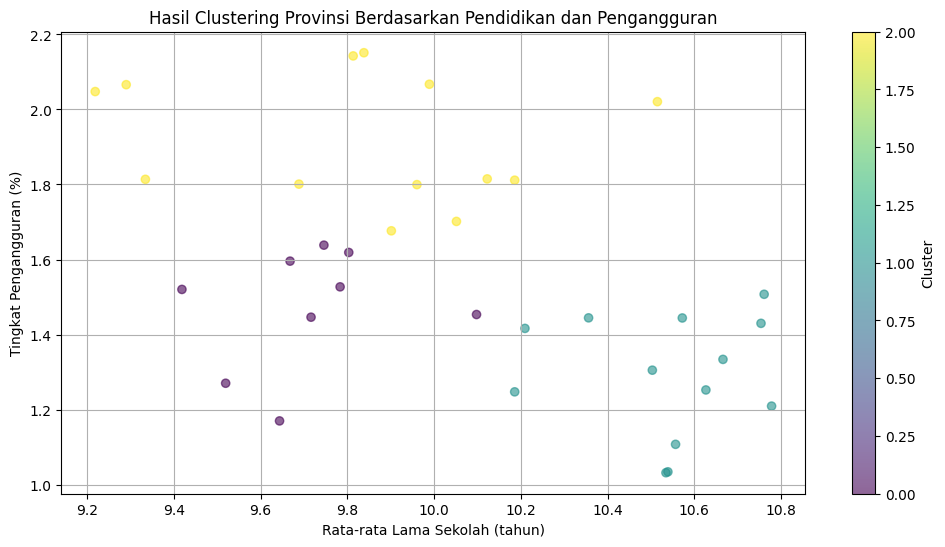

In [91]:
plt.figure(figsize=(12, 6))

scatter = plt.scatter(df['Pendidikan_RataRata'], df['Tingkat_Pengangguran'],
                     c=df['cluster'],
                     cmap='viridis',
                     alpha=0.6)
plt.xlabel('Rata-rata Lama Sekolah (tahun)')
plt.ylabel('Tingkat Pengangguran (%)')
plt.title('Hasil Clustering Provinsi Berdasarkan Pendidikan dan Pengangguran')

plt.colorbar(scatter, label='Cluster')

plt.grid(True)

plt.show()

In [92]:
import pandas as pd

# Contoh load data (ganti sesuai file kamu)
df = pd.read_csv("dataset_tubes.csv")

# Pastikan kolom sudah dihitung kalau belum ada
df['Total_Pendidikan_Terpenuhi'] = (
    df['Tidak/belum pernah sekolah'] * 0 +
    df['Tidak/belum tamat SD'] * 3 +
    df['SD'] * 6 +
    df['SLTP'] * 9 +
    df['SLTA Umum/SMU'] * 12 +
    df['SLTA Kejuruan/SMK'] * 12 +
    df['Akademi/Diploma'] * 14 +
    df['Universitas'] * 16
)
df['Pendidikan_RataRata'] = df['Total_Pendidikan_Terpenuhi'] / df['Total']

# Simulasi pengangguran (jika belum ada di data)
import numpy as np
np.random.seed(42)
df['Tingkat_Pengangguran'] = 12 * np.exp(-0.2 * df['Pendidikan_RataRata']) + np.random.normal(0, 0.3, size=len(df))
df['Tingkat_Pengangguran'] = df['Tingkat_Pengangguran'].clip(lower=1)


In [93]:
# Scatter plot Pendidikan vs Pengangguran
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys

# --- Simulasi Data (Jika belum ada df) ---
try:
    df  # cek apakah df sudah ada
except NameError:
    # Buat data dummy kalau belum ada df
    np.random.seed(42)
    pendidikan = np.random.uniform(5, 15, 50)
    pengangguran = 12 * np.exp(-0.2 * pendidikan) + np.random.normal(0, 0.3, size=50)
    pengangguran = np.clip(pengangguran, 1, None)

    df = pd.DataFrame({
        'Pendidikan_RataRata': pendidikan,
        'Tingkat_Pengangguran': pengangguran
    })

# --- Plot Visualisasi ---
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Pendidikan_RataRata', y='Tingkat_Pengangguran', alpha=0.6)
plt.title('Scatter Plot Rata-rata Pendidikan vs Tingkat Pengangguran')
plt.xlabel('Rata-rata Lama Sekolah (tahun)')
plt.ylabel('Tingkat Pengangguran (%)')
plt.grid(True)
plt.tight_layout()

if 'streamlit' in sys.modules:
    import streamlit as st
    st.pyplot(plt.gcf())
else:
    plt.show()

plt.close()


2025-06-16 11:53:59.929 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


2025-06-16 11:54:00.140 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-16 11:54:00.141 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


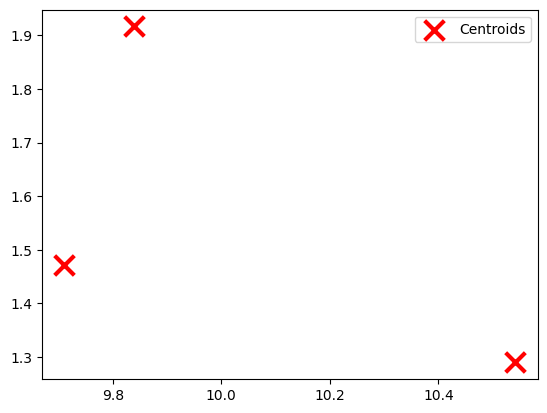

In [94]:
centroids = final_kmeans.cluster_centers_
centroids_original = scaler.inverse_transform(centroids)
plt.scatter(centroids_original[:, 0], centroids_original[:, 1],
           c='red', marker='x', s=200, linewidths=3,
           label='Centroids')
plt.legend()
plt.show()

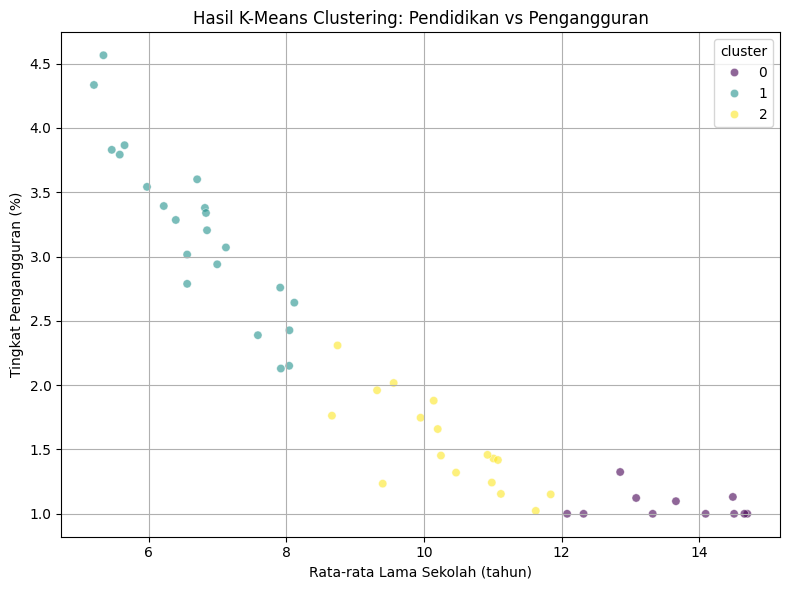


Karakteristik Cluster:

Cluster 0:
- Jumlah data: 11
- Rata-rata Pendidikan: 13.62 tahun
- Rata-rata Tingkat Pengangguran: 1.06 %

Cluster 1:
- Jumlah data: 22
- Rata-rata Pendidikan: 6.72 tahun
- Rata-rata Tingkat Pengangguran: 3.20 %

Cluster 2:
- Jumlah data: 17
- Rata-rata Pendidikan: 10.31 tahun
- Rata-rata Tingkat Pengangguran: 1.54 %


In [95]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# --- Simulasi Data jika df belum ada ---
np.random.seed(42)
pendidikan = np.random.uniform(5, 15, 50)
pengangguran = 12 * np.exp(-0.2 * pendidikan) + np.random.normal(0, 0.3, size=50)
pengangguran = np.clip(pengangguran, 1, None)

df = pd.DataFrame({
    'Pendidikan_RataRata': pendidikan,
    'Tingkat_Pengangguran': pengangguran
})

# --- Proses KMeans Clustering ---
X_clustering = df[['Pendidikan_RataRata', 'Tingkat_Pengangguran']]
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X_clustering)

# --- Visualisasi Clustering ---
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Pendidikan_RataRata', y='Tingkat_Pengangguran',
                hue='cluster', palette='viridis', alpha=0.6)
plt.title('Hasil K-Means Clustering: Pendidikan vs Pengangguran')
plt.xlabel('Rata-rata Lama Sekolah (tahun)')
plt.ylabel('Tingkat Pengangguran (%)')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Karakteristik Tiap Cluster ---
print("\nKarakteristik Cluster:")
for i in sorted(df['cluster'].unique()):
    cluster_data = df[df['cluster'] == i]
    print(f"\nCluster {i}:")
    print(f"- Jumlah data: {len(cluster_data)}")
    print(f"- Rata-rata Pendidikan: {cluster_data['Pendidikan_RataRata'].mean():.2f} tahun")
    print(f"- Rata-rata Tingkat Pengangguran: {cluster_data['Tingkat_Pengangguran'].mean():.2f} %")


In [96]:
# --- Simpan model KMeans hasil clustering dinamis ---
model_filename = 'kmeans_model.pkl'

try:
    with open(model_filename, 'wb') as file:
        pickle.dump(kmeans_dynamic, file)
    st.success(f"Model KMeans berhasil disimpan sebagai '{model_filename}'")
except Exception as e:
    st.error(f"Gagal menyimpan model KMeans: {e}")


2025-06-16 11:54:00.881 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-16 11:54:00.882 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


## Decision Tree Regression

In [97]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [98]:
# Persiapan data
X = df[['Pendidikan_RataRata']]
y = df['Tingkat_Pengangguran']

In [99]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [100]:
# Buat dan latih model Decision Tree
dt_model = DecisionTreeRegressor(
    max_depth=4,               # Sesuaikan dengan model awal kamu
    random_state=42
)
dt_model.fit(X_train, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,4
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [101]:
# Prediksi
y_pred = dt_model.predict(X_test)

In [102]:
# Evaluasi model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("=== Hasil Analisis Decision Tree ===")
print(f"R-squared (R²): {r2:.4f}")
print(f"Root Mean Square Error (RMSE): {rmse:.2f}")

=== Hasil Analisis Decision Tree ===
R-squared (R²): 0.8200
Root Mean Square Error (RMSE): 0.41


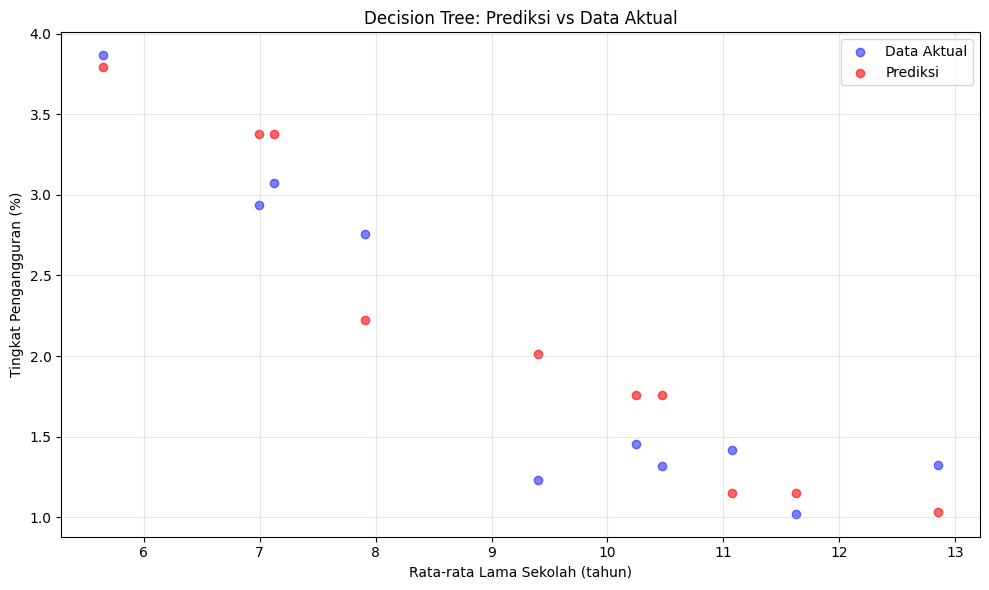

In [103]:
# Visualisasi: Data aktual vs prediksi
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='blue', alpha=0.5, label='Data Aktual')
plt.scatter(X_test, y_pred, color='red', alpha=0.6, label='Prediksi')
plt.xlabel('Rata-rata Lama Sekolah (tahun)')
plt.ylabel('Tingkat Pengangguran (%)')
plt.title('Decision Tree: Prediksi vs Data Aktual')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

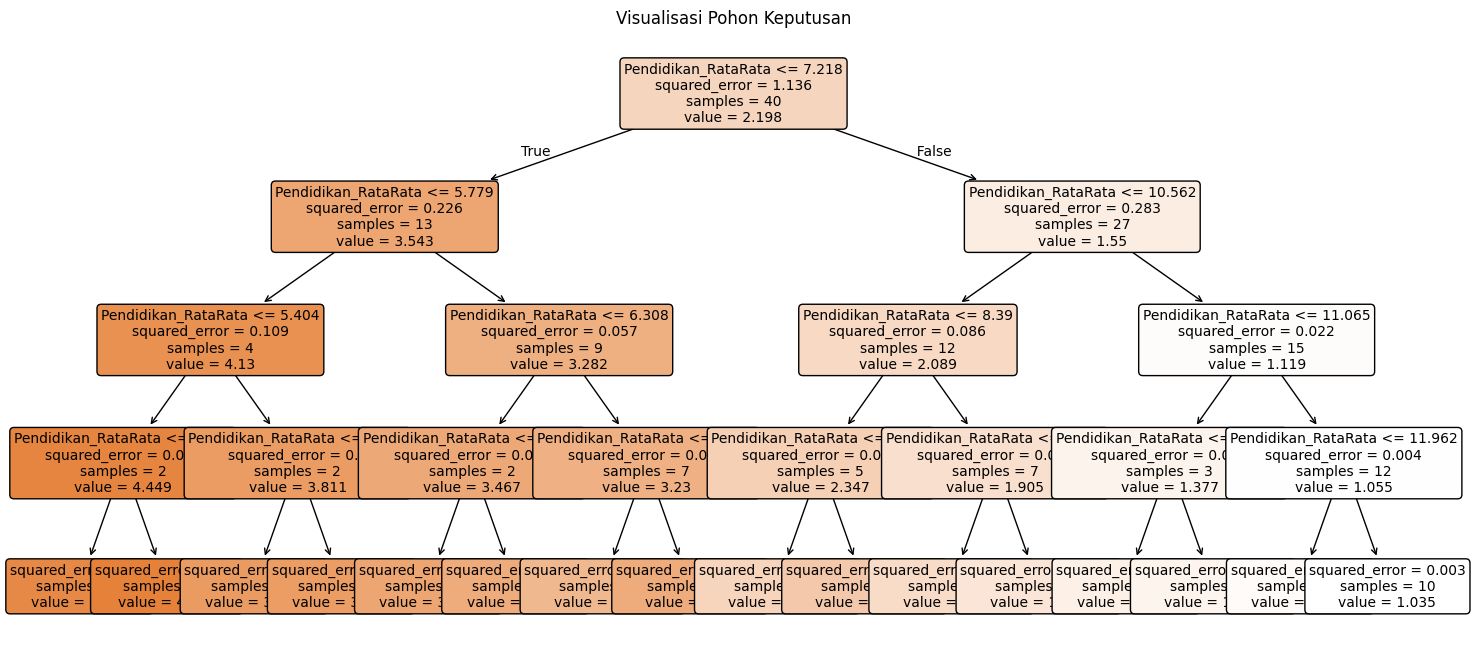

In [104]:
# Visualisasi Pohon Keputusan
plt.figure(figsize=(18, 8))
plot_tree(dt_model, feature_names=['Pendidikan_RataRata'],
          filled=True, rounded=True, fontsize=10)
plt.title('Visualisasi Pohon Keputusan')
plt.show()

In [105]:
# Feature Importance
importance = dt_model.feature_importances_
print("\nFeature Importance:")
for feature, imp in zip(['Pendidikan_RataRata'], importance):
    print(f"{feature}: {imp:.4f}")


Feature Importance:
Pendidikan_RataRata: 1.0000


In [106]:
# Residual Analysis
residuals = y_test - y_pred

plt.figure(figsize=(12, 5))

<Figure size 1200x500 with 0 Axes>

In [107]:
# Histogram residual
plt.subplot(1, 2, 1)
plt.hist(residuals, bins=30, edgecolor='black')
plt.title('Distribusi Residual')
plt.xlabel('Residual')
plt.ylabel('Frekuensi')

Text(0, 0.5, 'Frekuensi')

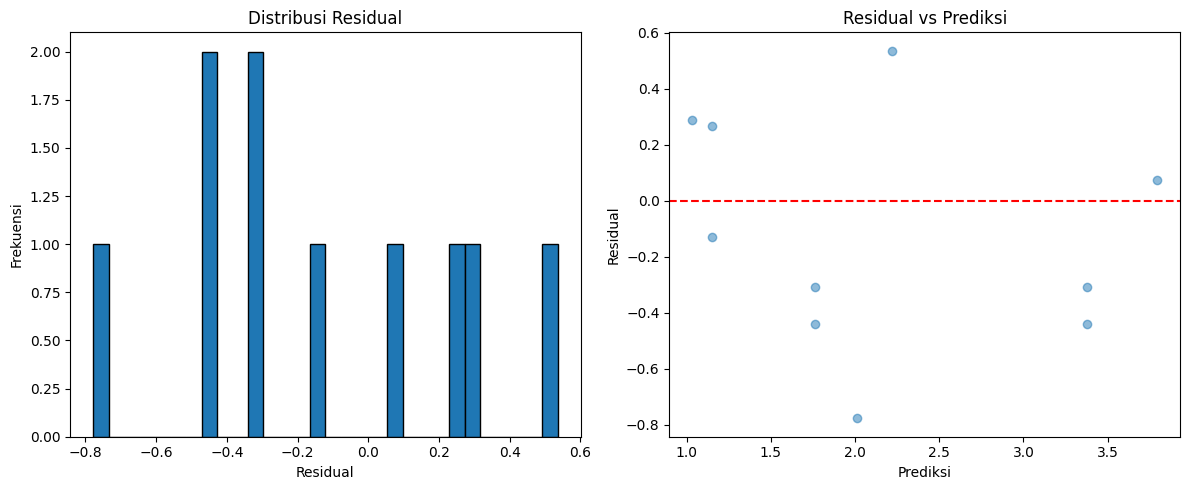

In [108]:
# Scatter residual vs prediksi
plt.subplot(1, 2, 2)
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residual vs Prediksi')
plt.xlabel('Prediksi')
plt.ylabel('Residual')

plt.tight_layout()
plt.show()

In [109]:
# Simpan model
model_filename = 'decision_tree_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(dt_model, file)

print(f"\n✅ Model Decision Tree berhasil disimpan sebagai '{model_filename}'")


✅ Model Decision Tree berhasil disimpan sebagai 'decision_tree_model.pkl'


## Regresi Linear: Pengaruh Pendidikan terhadap Pengangguran

In [110]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_linreg_pred = linreg.predict(X_test)

r2_linreg = r2_score(y_test, y_linreg_pred)
rmse_linreg = np.sqrt(mean_squared_error(y_test, y_linreg_pred))

print(f"R2 Score (Linear Regression): {r2_linreg:.4f}")
print(f"RMSE (Linear Regression): {rmse_linreg:.2f}")

R2 Score (Linear Regression): 0.7754
RMSE (Linear Regression): 0.45


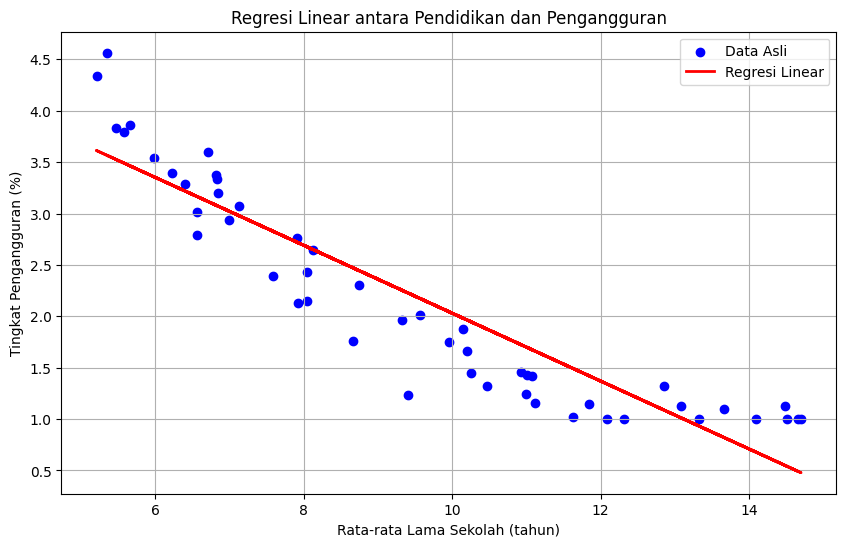

In [111]:
plt.figure(figsize=(10,6))
plt.scatter(X, y, color='blue', label='Data Asli')
plt.plot(X, linreg.predict(X), color='red', linewidth=2, label='Regresi Linear')
plt.xlabel('Rata-rata Lama Sekolah (tahun)')
plt.ylabel('Tingkat Pengangguran (%)')
plt.title('Regresi Linear antara Pendidikan dan Pengangguran')
plt.legend()
plt.grid(True)
plt.show()

In [112]:
from IPython.display import display, Markdown
display(Markdown("### Perbandingan Performa Model Regresi"))

print("=== Perbandingan Performa Model ===")
print(f"R² Linear Regression  : {r2_linreg:.4f}")
print(f"RMSE Linear Regression: {rmse_linreg:.2f}")
print(f"R² Decision Tree      : {r2:.4f}")
print(f"RMSE Decision Tree    : {rmse:.2f}")

print("\n>>> Analisis Performa:")
if r2 > r2_linreg:
    print("- Model Decision Tree memiliki akurasi (R²) yang lebih tinggi.")
else:
    print("- Model Linear Regression memiliki akurasi (R²) yang lebih tinggi.")

if rmse < rmse_linreg:
    print("- Model Decision Tree menghasilkan error yang lebih kecil (RMSE).")
else:
    print("- Model Linear Regression menghasilkan error yang lebih kecil (RMSE).")


### Perbandingan Performa Model Regresi

=== Perbandingan Performa Model ===
R² Linear Regression  : 0.7754
RMSE Linear Regression: 0.45
R² Decision Tree      : 0.8200
RMSE Decision Tree    : 0.41

>>> Analisis Performa:
- Model Decision Tree memiliki akurasi (R²) yang lebih tinggi.
- Model Decision Tree menghasilkan error yang lebih kecil (RMSE).


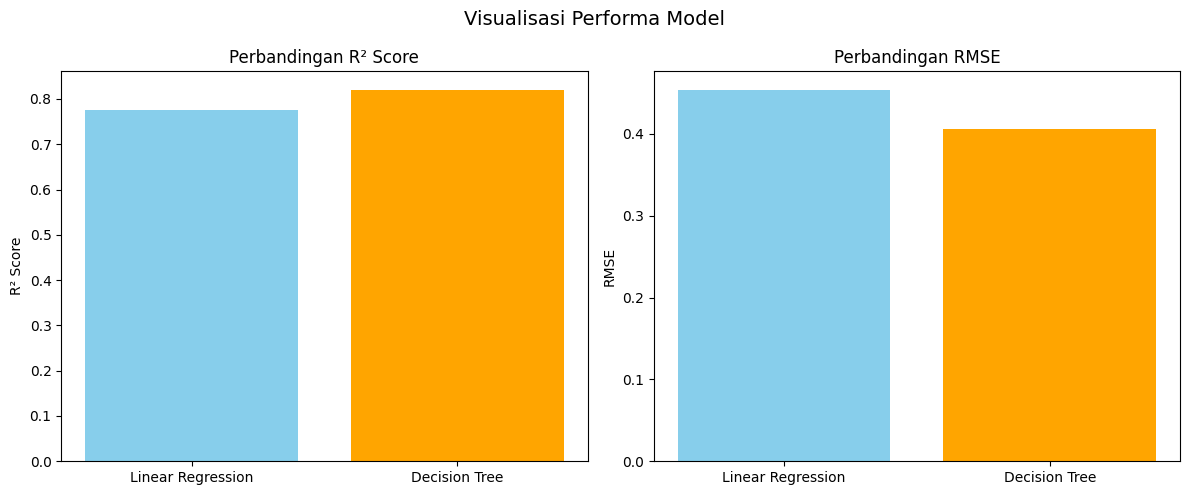

In [113]:
import matplotlib.pyplot as plt

models = ['Linear Regression', 'Decision Tree']
r2_scores = [r2_linreg, r2]
rmse_scores = [rmse_linreg, rmse]

plt.figure(figsize=(12, 5))

# Bar chart R²
plt.subplot(1, 2, 1)
plt.bar(models, r2_scores, color=['skyblue', 'orange'])
plt.title('Perbandingan R² Score')
plt.ylabel('R² Score')

# Bar chart RMSE
plt.subplot(1, 2, 2)
plt.bar(models, rmse_scores, color=['skyblue', 'orange'])
plt.title('Perbandingan RMSE')
plt.ylabel('RMSE')

plt.suptitle("Visualisasi Performa Model", fontsize=14)
plt.tight_layout()
plt.show()

In [114]:
import pickle
import os
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


filename_linreg = 'linear_regression_model.pkl'
try:
    with open(filename_linreg, 'wb') as f:
        pickle.dump(linreg, f)
    print(f"Linear Regression model successfully saved to '{filename_linreg}'")
except NameError:
    print(f"Error: 'linreg' variable not found. Please train your Linear Regression model before saving.")
except Exception as e:
    print(f"Error saving Linear Regression model: {e}")


# Save Decision Tree model
filename_tree = 'decision_tree_model.pkl'
try:
    with open(filename_tree, 'wb') as f:
        pickle.dump(tree, f)
    print(f"Decision Tree model successfully saved to '{filename_tree}'")
except NameError:
     print(f"Error: 'tree' variable not found. Please train your Decision Tree model before saving.")
except Exception as e:
    print(f"Error saving Decision Tree model: {e}")

# Save KMeans Clustering model
filename_kmeans = 'kmeans_model.pkl'
try:
    with open(filename_kmeans, 'wb') as f:
        pickle.dump(final_kmeans, f) # Make sure 'final_kmeans' is the correct variable name
    print(f"KMeans Clustering model successfully saved to '{filename_kmeans}'")
except NameError:
     print(f"Error: 'final_kmeans' variable not found. Please train your KMeans model before saving.")
except Exception as e:
    print(f"Error saving KMeans Clustering model: {e}")

# Save the Scaler used for KMeans clustering
filename_scaler = 'scaler.pkl'
try:
    with open(filename_scaler, 'wb') as f:
        pickle.dump(scaler, f) # Make sure 'scaler' is the correct variable name
    print(f"Scaler successfully saved to '{filename_scaler}'")
except NameError:
     print(f"Error: 'scaler' variable not found. Please fit and save your StandardScaler.")
except Exception as e:
    print(f"Error saving Scaler: {e}")

Linear Regression model successfully saved to 'linear_regression_model.pkl'
Error: 'tree' variable not found. Please train your Decision Tree model before saving.
KMeans Clustering model successfully saved to 'kmeans_model.pkl'
Scaler successfully saved to 'scaler.pkl'


In [115]:
!pip install pyngrok

In [116]:
!ngrok config add-authtoken 2wsvRjbCjOiSOWuCLUoF5W6Pvzz_7GRCWdv5Yi6ynKhNzgYff

Authtoken saved to configuration file: C:\Users\M. Hafiz Andrean\AppData\Local/ngrok/ngrok.yml


In [117]:
import streamlit as st
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_text # Import plot_tree and export_text
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, r2_score, mean_squared_error
import os

st.set_page_config(
    page_title="Analisis Pengaruh Pendidikan terhadap Tingkat Pengangguran",
    page_icon="📊",
    layout="wide"
)

st.title("Analisis Pengaruh Tingkat Pendidikan terhadap Tingkat Pengangguran di Indonesia")

# --- Data Loading and Preparation ---
st.subheader("Data Loading and Preparation")

uploaded_file = st.file_uploader("Upload dataset CSV", type="csv")

df = None # Initialize df to None

if uploaded_file:
    try:
        df = pd.read_csv(uploaded_file)

        # Data Preparation Steps from your notebook
        tahun_pendidikan = {
            'Tidak/belum pernah sekolah': 0,
            'Tidak/belum tamat SD': 3,
            'SD': 6,
            'SLTP': 9,
            'SLTA Umum/SMU': 12,
            'SLTA Kejuruan/SMK': 12,
            'Akademi/Diploma': 14,
            'Universitas': 16
        }

        # Ensure necessary columns exist before accessing them
        required_edu_cols = list(tahun_pendidikan.keys()) + ['Total']
        if not all(col in df.columns for col in required_edu_cols):
            st.error("Error: Dataset is missing required education level columns or 'Total'.")
            df = None # Invalidate df if columns are missing
        else:
            df['Total_Pendidikan_Terpenuhi'] = 0
            for level, years in tahun_pendidikan.items():
                df['Total_Pendidikan_Terpenuhi'] += df[level] * years

            # Handle potential division by zero if 'Total' is zero
            df['Pendidikan_RataRata'] = df.apply(
                lambda row: row['Total_Pendidikan_Terpenuhi'] / row['Total'] if row['Total'] > 0 else 0,
                axis=1
            )

            # Simulate 'Tingkat_Pengangguran' as done in your notebook
            # NOTE: In a real scenario, this column would be in your dataset.
            # Since you simulated it, we'll keep the simulation here for demonstration.
            np.random.seed(42)
            df['Tingkat_Pengangguran'] = 12 * np.exp(-0.2 * df['Pendidikan_RataRata']) + np.random.normal(0, 0.3, size=len(df))
            df['Tingkat_Pengangguran'] = df['Tingkat_Pengangguran'].clip(lower=1) # minimal 1%


            st.success("Data loaded and prepared successfully!")
            if 'Periode' in df.columns:
                 st.dataframe(df[['Periode', 'Pendidikan_RataRata', 'Tingkat_Pengangguran']].head())
            else:
                 st.dataframe(df[['Pendidikan_RataRata', 'Tingkat_Pengangguran']].head())


    except Exception as e:
        st.error(f"Error loading or preparing data: {e}")
        df = None # Invalidate df on any loading/preparation error

# --- Model Loading ---
st.subheader("Model Loading")

# Define the expected model filenames
linear_regression_model_file = 'linear_regression_model.pkl'
decision_tree_model_file = 'decision_tree_model.pkl'
kmeans_model_file = 'kmeans_model.pkl'
scaler_file = 'scaler.pkl' # Assuming you saved the scaler too

models = {}
scaler = None
model_loading_success = True

# Check if model files exist before attempting to load
if os.path.exists(linear_regression_model_file) and \
   os.path.exists(decision_tree_model_file) and \
   os.path.exists(kmeans_model_file) and \
   os.path.exists(scaler_file):

    try:
        # Load Linear Regression model
        with open(linear_regression_model_file, 'rb') as f:
            models['Linear Regression'] = pickle.load(f)
        st.success(f"Linear Regression model loaded from '{linear_regression_model_file}'")

        # Load Decision Tree model
        with open(decision_tree_model_file, 'rb') as f:
            models['Decision Tree'] = pickle.load(f)
        st.success(f"Decision Tree model loaded from '{decision_tree_model_file}'")

        # Load KMeans model
        with open(kmeans_model_file, 'rb') as f:
            models['KMeans Clustering'] = pickle.load(f)
        st.success(f"KMeans Clustering model loaded from '{kmeans_model_file}'")

        # Load Scaler
        with open(scaler_file, 'rb') as f:
            scaler = pickle.load(f)
        st.success(f"Scaler loaded from '{scaler_file}'")

    except Exception as e:
        st.error(f"Error loading models: {e}")
        models = {} # Clear models if loading fails
        scaler = None
        model_loading_success = False
else:
    st.warning("Model files not found. Please ensure 'linear_regression_model.pkl', 'decision_tree_model.pkl', 'kmeans_model.pkl', and 'scaler.pkl' are in the same directory.")
    model_loading_success = False


# --- Model Application and Visualization ---
# Proceed only if data is loaded and models are loaded successfully
if df is not None and models and scaler is not None and model_loading_success:
    st.subheader("Model Results and Visualizations")

    # --- K-Means Clustering with Button ---
    if 'KMeans Clustering' in models:
        st.write("#### K-Means Clustering")

        # Allow user to select the number of clusters
        n_clusters_input = st.slider(
            "Select the number of clusters for K-Means:",
            min_value=2,
            max_value=10,
            value=models['KMeans Clustering'].n_clusters, # Default to loaded model's clusters
            step=1
        )

        # Add a button to trigger clustering
        if st.button(f'Perform K-Means Clustering with {n_clusters_input} clusters'):
             try:
                features_for_clustering = ['Pendidikan_RataRata', 'Tingkat_Pengangguran']
                if not all(col in df.columns for col in features_for_clustering):
                     st.error(f"Clustering features {features_for_clustering} not found in data.")
                else:
                    X_clustering = df[features_for_clustering]
                    X_clustering_scaled = scaler.transform(X_clustering) # Use the loaded scaler

                    # Perform K-Means clustering with the selected number of clusters
                    kmeans_dynamic = KMeans(n_clusters=n_clusters_input, random_state=42, n_init=10) # Specify n_init
                    df['cluster'] = kmeans_dynamic.fit_predict(X_clustering_scaled)

                    cluster_summary = df.groupby('cluster').agg({
                        'Pendidikan_RataRata': 'mean',
                        'Tingkat_Pengangguran': 'mean',
                         'Periode': 'count' if 'Periode' in df.columns else ('Pendidikan_RataRata', 'count') # Count using any column if Periode is missing
                    }).round(2)
                    cluster_summary.rename(columns={cluster_summary.columns[-1]: 'Jumlah Data'}, inplace=True) # Rename the last column to Jumlah Data


                    st.write(f"Cluster Summary ({n_clusters_input} clusters):")
                    st.dataframe(cluster_summary)

                    fig, ax = plt.subplots(figsize=(12, 6))
                    scatter = ax.scatter(df['Pendidikan_RataRata'], df['Tingkat_Pengangguran'],
                                         c=df['cluster'],
                                         cmap='viridis',
                                         alpha=0.6)
                    ax.set_xlabel('Rata-rata Lama Sekolah (tahun)')
                    ax.set_ylabel('Tingkat Pengangguran (%)')
                    ax.set_title(f'Hasil Clustering Provinsi Berdasarkan Pendidikan dan Pengangguran ({n_clusters_input} Clusters)')
                    fig.colorbar(scatter, label='Cluster')
                    ax.grid(True)
                    st.pyplot(fig)
                    plt.close(fig) # Close figure

             except Exception as e:
                st.error(f"Error performing K-Means Clustering: {e}")
        else:
            st.info("Click the button to perform K-Means Clustering with the selected number of clusters.")


    # --- Linear Regression ---
    if 'Linear Regression' in models:
        st.write("#### Regresi Linear")
        try:
            # Use the full data for visualization as in your notebook
            X_linreg = df[['Pendidikan_RataRata']]
            y_linreg = df['Tingkat_Pengangguran']

            # Predict using the loaded model
            y_linreg_pred = models['Linear Regression'].predict(X_linreg)

            st.write("Regresi Linear Model Applied.")

            # Plot
            fig, ax = plt.subplots(figsize=(10, 6))
            ax.scatter(X_linreg, y_linreg, color='blue', alpha=0.6, label='Data Asli')
            ax.plot(X_linreg, y_linreg_pred, color='red', linewidth=2, label='Regresi Linear')
            ax.set_xlabel('Rata-rata Lama Sekolah (tahun)')
            ax.set_ylabel('Tingkat Pengangguran (%)')
            ax.set_title('Regresi Linear antara Pendidikan dan Pengangguran')
            ax.legend()
            ax.grid(True)
            st.pyplot(fig)
            plt.close(fig) # Close figure

            # Calculate and display R2 and RMSE
            linreg_r2 = r2_score(y_linreg, y_linreg_pred)
            linreg_mse = mean_squared_error(y_linreg, y_linreg_pred)
            linreg_rmse = np.sqrt(linreg_mse)

            st.write("##### Model Performance")
            st.write(f"R2 Score: {linreg_r2:.4f}")
            st.write(f"RMSE: {linreg_rmse:.2f}")


        except Exception as e:
            st.error(f"Error applying Linear Regression: {e}")

    # --- Decision Tree Regression ---
    if 'Decision Tree' in models:
        st.write("#### Decision Tree Regression")
        try:
            # Use the full data for visualization/application
            X_tree = df[['Pendidikan_RataRata']]
            y_tree = df['Tingkat_Pengangguran']

            # Predict using the loaded model
            y_tree_pred = models['Decision Tree'].predict(X_tree)

            st.write("Decision Tree Model Applied.")

            # --- Visualisasi Pohon Keputusan ---
            st.subheader("Visualisasi Pohon Keputusan")
            try:
                # Decision Tree plot can be large, handle figure creation
                fig, ax = plt.subplots(figsize=(20, 10))
                # Make sure 'Pendidikan_RataRata' is the correct feature name
                plot_tree(models['Decision Tree'], feature_names=['Pendidikan_RataRata'],
                         filled=True, rounded=True, fontsize=10, ax=ax)
                ax.set_title('Visualisasi Pohon Keputusan') # Set title using ax
                st.pyplot(fig)
                plt.close(fig) # Close figure to free memory
            except Exception as e:
                st.warning(f"Could not generate Decision Tree visualization: {e}")

            # --- Text representation of the tree ---
            st.write("##### Decision Tree Structure (Text)")
            try:
                r = export_text(models['Decision Tree'], feature_names=['Pendidikan_RataRata'])
                st.text(r)
            except Exception as e:
                st.warning(f"Could not generate text tree representation: {e}")


            # --- Plot Prediksi vs Aktual ---
            st.subheader("Prediksi vs Aktual (Decision Tree)")
            # Use the 'Pendidikan_RataRata' and 'Tingkat_Pengangguran' columns from the data
            X_data = df[['Pendidikan_RataRata']]
            y_actual = df['Tingkat_Pengangguran'] # Use the actual target variable
            y_pred_dt = models['Decision Tree'].predict(X_data) # Predict using the loaded model for DT

            fig, ax = plt.subplots(figsize=(10, 6))
            ax.scatter(X_data, y_actual, color='blue', alpha=0.5, label='Aktual')
            ax.scatter(X_data, y_pred_dt, color='green', alpha=0.5, label='Prediksi (Decision Tree)')
            ax.legend()
            ax.set_title('Perbandingan Tingkat Pengangguran Aktual vs Prediksi (Decision Tree)')
            ax.set_xlabel('Rata-rata Lama Sekolah (tahun)')
            ax.set_ylabel('Tingkat Pengangguran (%)')

             # Calculate R² and RMSE (vs actual Tingkat_Pengangguran)
            try:
                dt_r2 = r2_score(y_actual, y_pred_dt)
                dt_mse = mean_squared_error(y_actual, y_pred_dt)
                dt_rmse = np.sqrt(dt_mse)

                st.write("##### Model Performance")
                st.write(f"R2 Score: {dt_r2:.4f}")
                st.write(f"RMSE: {dt_rmse:.2f}")
            except Exception as e:
                st.warning(f"Could not calculate R² or RMSE: {e}")

            st.pyplot(fig)
            plt.close(fig) # Close figure


        except Exception as e:
            st.error(f"Error applying Decision Tree Regression: {e}")

    # --- Perbandingan Performa Model Regresi ---
    st.subheader("Perbandingan Performa Model Regresi")

    # Tampilkan metrik performa
    st.markdown(f"""
    **R² Score Linear Regression**: `{linreg_r2:.4f}`  
    **RMSE Linear Regression**: `{linreg_rmse:.2f}`

    **R² Score Decision Tree**: `{dt_r2:.4f}`  
    **RMSE Decision Tree**: `{dt_rmse:.2f}`
    """)

    # Analisis performa
    st.markdown("#### Analisis Performa:")
    if dt_r2 > linreg_r2:
        st.write("- Model Decision Tree memiliki akurasi (R²) yang lebih tinggi.")
    else:
        st.write("- Model Linear Regression memiliki akurasi (R²) yang lebih tinggi.")

    if dt_rmse < linreg_rmse:
        st.write("- Model Decision Tree menghasilkan error (RMSE) yang lebih kecil.")
    else:
        st.write("- Model Linear Regression menghasilkan error (RMSE) yang lebih kecil.")

    # Visualisasi Perbandingan R² dan RMSE
    st.markdown("#### Visualisasi Perbandingan R² dan RMSE")
    import matplotlib.pyplot as plt

    models = ['Linear Regression', 'Decision Tree']
    r2_scores = [linreg_r2, dt_r2]
    rmse_scores = [linreg_rmse, dt_rmse]

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Bar plot R²
    axs[0].bar(models, r2_scores, color=['#4a90e2', '#f5a623'])
    axs[0].set_title('R² Score')
    axs[0].set_ylabel('R²')
    axs[0].set_ylim(0, 1)
    axs[0].grid(True)

    # Bar plot RMSE
    axs[1].bar(models, rmse_scores, color=['#4a90e2', '#f5a623'])
    axs[1].set_title('RMSE')
    axs[1].set_ylabel('RMSE')
    axs[1].grid(True)

    plt.suptitle('Perbandingan Performa Model')
    st.pyplot(fig)
    plt.close(fig)

    # --- Prediction Section with Button ---
    st.subheader("Make a Prediction")
    st.write("Enter a value for 'Rata-rata Lama Sekolah' to get predictions.")

    # Ensure the input value is within a reasonable range based on your data
    if df is not None and 'Pendidikan_RataRata' in df.columns:
        min_pendidikan = float(df['Pendidikan_RataRata'].min())
        max_pendidikan = float(df['Pendidikan_RataRata'].max())
        mean_pendidikan = float(df['Pendidikan_RataRata'].mean())
    else:
         # Fallback values if data is not loaded or column is missing
         min_pendidikan = 0.0
         max_pendidikan = 20.0
         mean_pendidikan = 10.0


    pendidikan_input_predict = st.slider(
        "Input Rata-rata Lama Sekolah (tahun) for Prediction:",
        min_value=min_pendidikan,
        max_value=max_pendidikan,
        value=mean_pendidikan,
        step=0.1 # Allow fractional input
    )

    # Add a button to trigger predictions
    if st.button('Get Predictions'):
        if 'Linear Regression' in models:
            try:
                # Reshape the input for prediction (needs to be 2D)
                input_for_prediction = np.array([[pendidikan_input_predict]])
                prediction_linreg = models['Linear Regression'].predict(input_for_prediction)
                st.write(f"Predicted Tingkat Pengangguran (Regresi Linear): {prediction_linreg[0]:.2f} %")
            except Exception as e:
                st.error(f"Error predicting with Linear Regression: {e}")


        if 'Decision Tree' in models:
             try:
                # Reshape the input for prediction (needs to be 2D)
                input_for_prediction = np.array([[pendidikan_input_predict]])
                prediction_tree = models['Decision Tree'].predict(input_for_prediction)
                st.write(f"Predicted Tingkat Pengangguran (Decision Tree): {prediction_tree[0]:.2f} %")
             except Exception as e:
                st.error(f"Error predicting with Decision Tree: {e}")

    else:
        st.info("Click the button to get predictions.")


# --- Conclusion ---
st.subheader("Kesimpulan dari Analisis Notebook")
st.markdown("""
Berdasarkan analisis yang dilakukan di notebook:
- *K-Means Clustering* membantu mengelompokkan provinsi berdasarkan pola pendidikan dan pengangguran.
- Model *Decision Tree* menunjukkan struktur pengambilan keputusan yang potensial untuk prediksi.
- *Regresi Linear* menunjukkan hubungan linier negatif antara rata-rata pendidikan dan tingkat pengangguran.
- Model ini dapat membantu perumusan kebijakan pendidikan dalam upaya mengurangi pengangguran di Indonesia.
""")

2025-06-16 11:54:07.842 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-16 11:54:07.844 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-16 11:54:07.845 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-16 11:54:07.845 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-16 11:54:07.846 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-16 11:54:07.846 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-16 11:54:07.847 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-16 11:54:07.847 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

2025-06-16 11:54:07.860 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-16 11:54:07.861 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-16 11:54:07.862 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-16 11:54:07.863 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-16 11:54:07.866 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-16 11:54:07.867 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-16 11:54:07.868 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-16 11:54:07.868 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

DeltaGenerator()

In [ ]:
!streamlit run app.py


## Kesimpulan
- **K-Means Clustering** mengelompokkan provinsi berdasarkan pola pendidikan dan pengangguran.
- **Decision Tree** menunjukkan struktur pengambilan keputusan yang bisa digunakan untuk prediksi.
- **Regresi Linear** memperlihatkan hubungan linier negatif antara rata-rata pendidikan dan tingkat pengangguran.
- Model ini dapat membantu perumusan kebijakan pendidikan dalam upaya mengurangi pengangguran di Indonesia.